In [43]:
import datetime
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA, IncrementalPCA, FastICA
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [44]:
train = pd.read_csv("data/train.csv", index_col="ID")
test = pd.read_csv("data/test.csv", index_col="ID")

In [45]:
# process columns, apply LabelEncoder to categorical features
for c in train.columns:
    if train[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder() 
        lbl.fit(list(train[c].values) + list(test[c].values)) 
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values))

# shape        
print('Shape train: {}\nShape test: {}'.format(train.shape, test.shape))

Shape train: (4209, 377)
Shape test: (4209, 376)


In [46]:
from sklearn.decomposition import PCA, FastICA, TruncatedSVD
n_comp = 24

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=42)
tsvd_results_train = tsvd.fit_transform(train.drop(["y"], axis=1))
tsvd_results_test = tsvd.transform(test)

# PCA
pca = PCA(n_components=n_comp, random_state=42)
pca2_results_train = pca.fit_transform(train.drop(["y"], axis=1))
pca2_results_test = pca.transform(test)

# ICA
ica = FastICA(n_components=n_comp, random_state=42)
ica2_results_train = ica.fit_transform(train.drop(["y"], axis=1))
ica2_results_test = ica.transform(test)

# Append decomposition components to datasets
for i in range(1, n_comp+1):
    train['pca_' + str(i)] = pca2_results_train[:,i-1]
    test['pca_' + str(i)] = pca2_results_test[:, i-1]
    
    train['ica_' + str(i)] = ica2_results_train[:,i-1]
    test['ica_' + str(i)] = ica2_results_test[:, i-1]
    
y_train = train["y"]
y_mean = np.mean(y_train)

In [47]:
y_mean = np.average(y_train)
y_mean

100.66931812782134

In [48]:
xgb_params = {
    "n_trees": 500,
    "eta": 0.005,
    "max_depth": 4,
    "subsample": 0.95,
    "objective": "reg:linear",
    "eval_metric": "rmse",
    "base_score": y_mean,
    "silent": 1,
    "seed": 0
}

In [49]:
dtrain = xgb.DMatrix(train.drop("y", axis=1), y_train)
dtest = xgb.DMatrix(test)

In [8]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=50, 
                   verbose_eval=50, show_stdv=False)

[0]	train-rmse:12.6394	test-rmse:12.6386
[50]	train-rmse:11.0646	test-rmse:11.1675
[100]	train-rmse:9.96328	test-rmse:10.1718
[150]	train-rmse:9.20709	test-rmse:9.52105
[200]	train-rmse:8.69087	test-rmse:9.10621
[250]	train-rmse:8.3385	test-rmse:8.84736
[300]	train-rmse:8.08363	test-rmse:8.69149
[350]	train-rmse:7.88008	test-rmse:8.60345
[400]	train-rmse:7.7154	test-rmse:8.56085
[450]	train-rmse:7.56902	test-rmse:8.53364
[500]	train-rmse:7.4398	test-rmse:8.52019
[550]	train-rmse:7.32404	test-rmse:8.51541
[600]	train-rmse:7.21954	test-rmse:8.51348


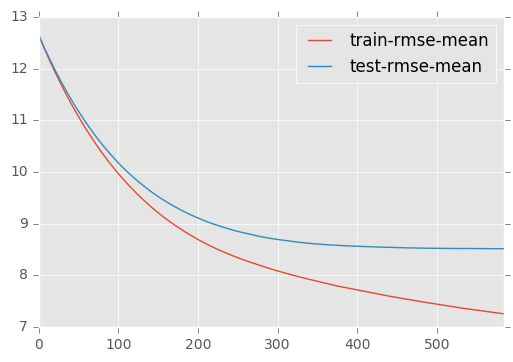

In [9]:
cv_output[["train-rmse-mean", "test-rmse-mean"]].plot()
pass

In [50]:
num_boost_rounds = 1500
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

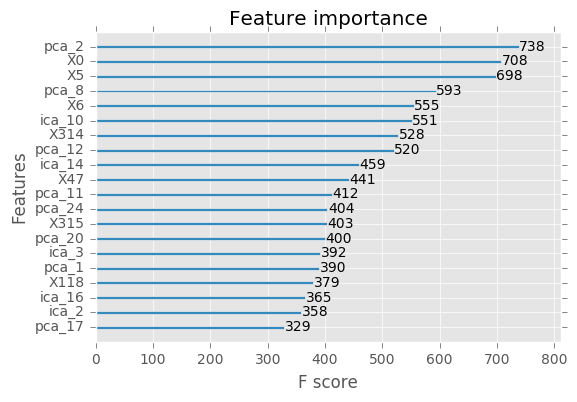

In [51]:
xgb.plot_importance(model, max_num_features=20)

In [52]:
y_pred = model.predict(dtrain)

In [53]:
r2_score(y_train, y_pred)

0.70530435718594475

### Prediction

In [54]:
y_predict = model.predict(dtest)

In [55]:
test.index

Int64Index([   1,    2,    3,    4,    5,    8,   10,   11,   12,   14,
            ...
            8401, 8404, 8407, 8408, 8409, 8410, 8411, 8413, 8414, 8416],
           dtype='int64', name='ID', length=4209)

In [56]:
output = pd.DataFrame({"ID": test.index, "y": y_predict})

In [57]:
output.head()

,ID,y
0,1,79.152420
1,2,93.702248
2,3,78.812523
3,4,77.024170
4,5,112.501160


In [58]:
output.to_csv("submissions_feature_reduction_{}.csv".format(datetime.datetime.today()), index=False)